# Primeiro Tech Challenge

**Aluno:** Vinícius Oliveira Litran Andrade.

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import statsmodels.api as sm

## Leitura dos dados

A base de dados utilizada neste projeto foi obtida do [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance). Esta base contém informações sobre custos médicos individuais cobrados pelo seguro de saúde, incluindo variáveis como idade, gênero, IMC, número de filhos, se a pessoa é fumante ou não, e a região onde reside. Esta base foi escolhida, pois é muito semelhante com a base proposta no exemplo presente de base do material que descreve o desafio.

In [2]:
# Lendo os Dadaos
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
#Trazendo os dados para o português
# Renomear as colunas 
df = df.rename(columns={ 'age': 'Idade', 'sex': 'Genero', 'bmi': 'IMC', 'children': 'Filhos', 'smoker': 'Fumante', 'region': 'Regiao', 'charges': 'Encargos'})

# Substituir valores em colunas qualitativas 
df['Genero'] = df['Genero'].replace({'female': 'feminino', 'male': 'masculino'})
df['Fumante'] = df['Fumante'].replace({'yes': 'sim', 'no': 'não'})
df['Regiao'] = df['Regiao'].replace({'southwest': 'sudoeste', 'southeast': 'sudeste', 'northwest': 'noroeste', 'northeast': 'nordeste'})
df.head()

,Idade,Genero,IMC,Filhos,Fumante,Regiao,Encargos
0,19,feminino,27.900,0,sim,sudoeste,16884.92400
1,18,masculino,33.770,1,não,sudeste,1725.55230
2,28,masculino,33.000,3,não,sudeste,4449.46200
3,33,masculino,22.705,0,não,noroeste,21984.47061
4,32,masculino,28.880,0,não,noroeste,3866.85520


## Informações do Dataset

Há 7 colunas no total, sendo elas:

- **Idade**: Idade do beneficiário principal. Tipo de dado: `int64`.
- **Gênero**: Gênero do beneficiário, podendo ser "feminino" ou "masculino". Tipo de dado: `object`.
- **IMC (Índice de Massa Corporal)**: Índice de massa corporal, fornecendo uma compreensão do peso corporal em relação à altura. Tipo de dado: `float64`.
- **Filhos**: Número de filhos cobertos pelo seguro de saúde / Número de dependentes. Tipo de dado: `int64`.
- **Fumante**: Indicador se o beneficiário é fumante, podendo ser "sim" ou "não". Tipo de dado: `object`.
- **Região**: Área residencial do beneficiário nos EUA, podendo ser "nordeste", "sudeste", "sudoeste" ou "noroeste". Tipo de dado: `object`.
- **Encargos**: Custos médicos individuais cobrados pelo seguro de saúde. Tipo de dado: `float64`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Idade     1338 non-null   int64  
 1   Genero    1338 non-null   object 
 2   IMC       1338 non-null   float64
 3   Filhos    1338 non-null   int64  
 4   Fumante   1338 non-null   object 
 5   Regiao    1338 non-null   object 
 6   Encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Pré-processamento dos dados para análise exploratória

Observa-se que há 1338 linhas e que nenhuma coluna possui valores nulos. Contudo, há um registro duplicado que será removido, totalizando 1337 linhas não nulas. Há também as colunas `Genero`, `Fumante` e `Regiao` que são categóricas e serão transformadas em formatos adequados para a modelagem e análise dos dados.


In [5]:
# Encontrar registros duplicados 
duplicados = df[df.duplicated()] 
# Exibir os registros duplicados 
print("Registros duplicados:") 
print(duplicados)

Registros duplicados:
     Idade     Genero    IMC  Filhos Fumante    Regiao   Encargos
581     19  masculino  30.59       0     não  noroeste  1639.5631


Remover registros duplicados é crucial para a qualidade e o desempenho de um modelo de Machine Learning, pois reduz o viés. Registros duplicados podem introduzir viés nos dados, fazendo com que o modelo aprenda padrões repetitivos que não representam a realidade. Isso pode levar a previsões menos precisas.

In [6]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

**Transformando Dados Categóricos:**

O `LabelEncoder` transforma os dados em sequência numérica (0, 1, 2, 3, etc.), o que, nesse caso, para as colunas `gênero` e `região`, não é aplicável. Em `gênero`, ficaria 0 para masculino e 1 para feminino. Isso poderia enviesar um dos dados como melhor, ou um dos dados como verdadeiro e outro como falso. A mesma situação poderia ocorrer para `região`, que colocaria as regiões em uma ordem numérica hierárquica, enviesando a aprendizagem do modelo. Logo, o ideal para as colunas `gênero` e `região` é aplicar o `OneHotEncoder`, transformando cada variante de dado em uma nova coluna, com valor `True` ou `False` (0 ou 1), indicando se o indivíduo é ou não do sexo feminino, é ou não de tal região, e assim por diante.

Para a coluna `fumante`, o `LabelEncoder` supre a necessidade, pois o "sim" e "não" já representam certo e errado, fuma ou não fuma, que é o mesmo que `True` ou `False`.

Para evitar Multicolinearidade da variavel gênero será considerado apenas a coluna Genero_masculino, pois Genero_masculino e Genero_femino são altamente correlacionadas e podem distorcer os coeficientes de regressão.

In [7]:
# Label Encoding na coluna "Fumante"
label_encoder = LabelEncoder()
df['Fumante'] = label_encoder.fit_transform(df['Fumante'])

# OneHot Encoding nas colunas "Genero" e "Regiao"
onehot_encoder = OneHotEncoder()
encoded_columns = onehot_encoder.fit_transform(df[['Genero', 'Regiao']]).toarray()
encoded_df = pd.DataFrame(encoded_columns, columns=onehot_encoder.get_feature_names_out(['Genero', 'Regiao']))

# Concatenando os DataFrames
df = pd.concat([df, encoded_df], axis=1).drop(['Genero', 'Regiao'], axis=1)
df[['Idade', 'Filhos']] = df[['Idade', 'Filhos']].astype('Int64')
df.drop(columns=['Genero_feminino'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Idade             1337 non-null   Int64  
 1   IMC               1337 non-null   float64
 2   Filhos            1337 non-null   Int64  
 3   Fumante           1337 non-null   int64  
 4   Encargos          1337 non-null   float64
 5   Genero_masculino  1337 non-null   float64
 6   Regiao_nordeste   1337 non-null   float64
 7   Regiao_noroeste   1337 non-null   float64
 8   Regiao_sudeste    1337 non-null   float64
 9   Regiao_sudoeste   1337 non-null   float64
dtypes: Int64(2), float64(7), int64(1)
memory usage: 107.2 KB


In [9]:
df.head()

,Idade,IMC,Filhos,Fumante,Encargos,Genero_masculino,Regiao_nordeste,Regiao_noroeste,Regiao_sudeste,Regiao_sudoeste
0,19,27.900,0,1,16884.92400,0.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0,3866.85520,1.0,0.0,1.0,0.0,0.0


## Ánalise exploratória dos dados

Os dados representam informações demográficas e de saúde de uma população.

- **Idade**: A média de idade é de aproximadamente 39 anos, com uma distribuição que varia de 18 a 64 anos. Isso sugere uma população adulta com uma boa representação de diferentes faixas etárias.
- **IMC (Índice de Massa Corporal)**: A média do IMC é de cerca de 30, o que indica que a maioria das pessoas está na faixa de sobrepeso. O IMC varia de 15,96 a 53,13, mostrando uma ampla gama de condições corporais.
- **Filhos**: A maioria das pessoas tem em média 1 filho, com um máximo de 5 filhos. Isso pode indicar uma tendência de famílias pequenas.
- **Fumante**: Apenas cerca de 20% da população é fumante.
- **Encargos**: Os encargos médios são de aproximadamente 13.279,12, com uma grande variação, indicando que algumas pessoas têm custos médicos significativamente mais altos do que outras.
- **Gênero masculino**: A distribuição de gênero é quase igual, com uma leve predominância masculina (50,5%).
- **Regiões**: A população está distribuída entre as regiões Nordeste, Noroeste, Sudeste e Sudoeste, com uma representação relativamente equilibrada entre elas.


In [10]:
# Análise dos dados de tipo numérico
df.describe()

,Idade,IMC,Filhos,Fumante,Encargos,Genero_masculino,Regiao_nordeste,Regiao_noroeste,Regiao_sudeste,Regiao_sudoeste
count,1337.0,1337.000000,1337.0,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,0.204936,13279.121487,0.504862,0.242334,0.242334,0.272251,0.243082
std,14.044333,6.100468,1.205571,0.403806,12110.359656,0.500163,0.428655,0.428655,0.445285,0.429104
min,18.0,15.960000,0.0,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.0,26.290000,0.0,0.000000,4746.344000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.0,30.400000,1.0,0.000000,9386.161300,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.0,34.700000,2.0,0.000000,16657.717450,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.0,53.130000,5.0,1.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<Axes: title={'center': 'Idade'}>,
        <Axes: title={'center': 'IMC'}>,
        <Axes: title={'center': 'Filhos'}>],
       [<Axes: title={'center': 'Fumante'}>,
        <Axes: title={'center': 'Encargos'}>,
        <Axes: title={'center': 'Genero_masculino'}>],
       [<Axes: title={'center': 'Regiao_nordeste'}>,
        <Axes: title={'center': 'Regiao_noroeste'}>,
        <Axes: title={'center': 'Regiao_sudeste'}>],
       [<Axes: title={'center': 'Regiao_sudoeste'}>, <Axes: >, <Axes: >]],
      dtype=object)

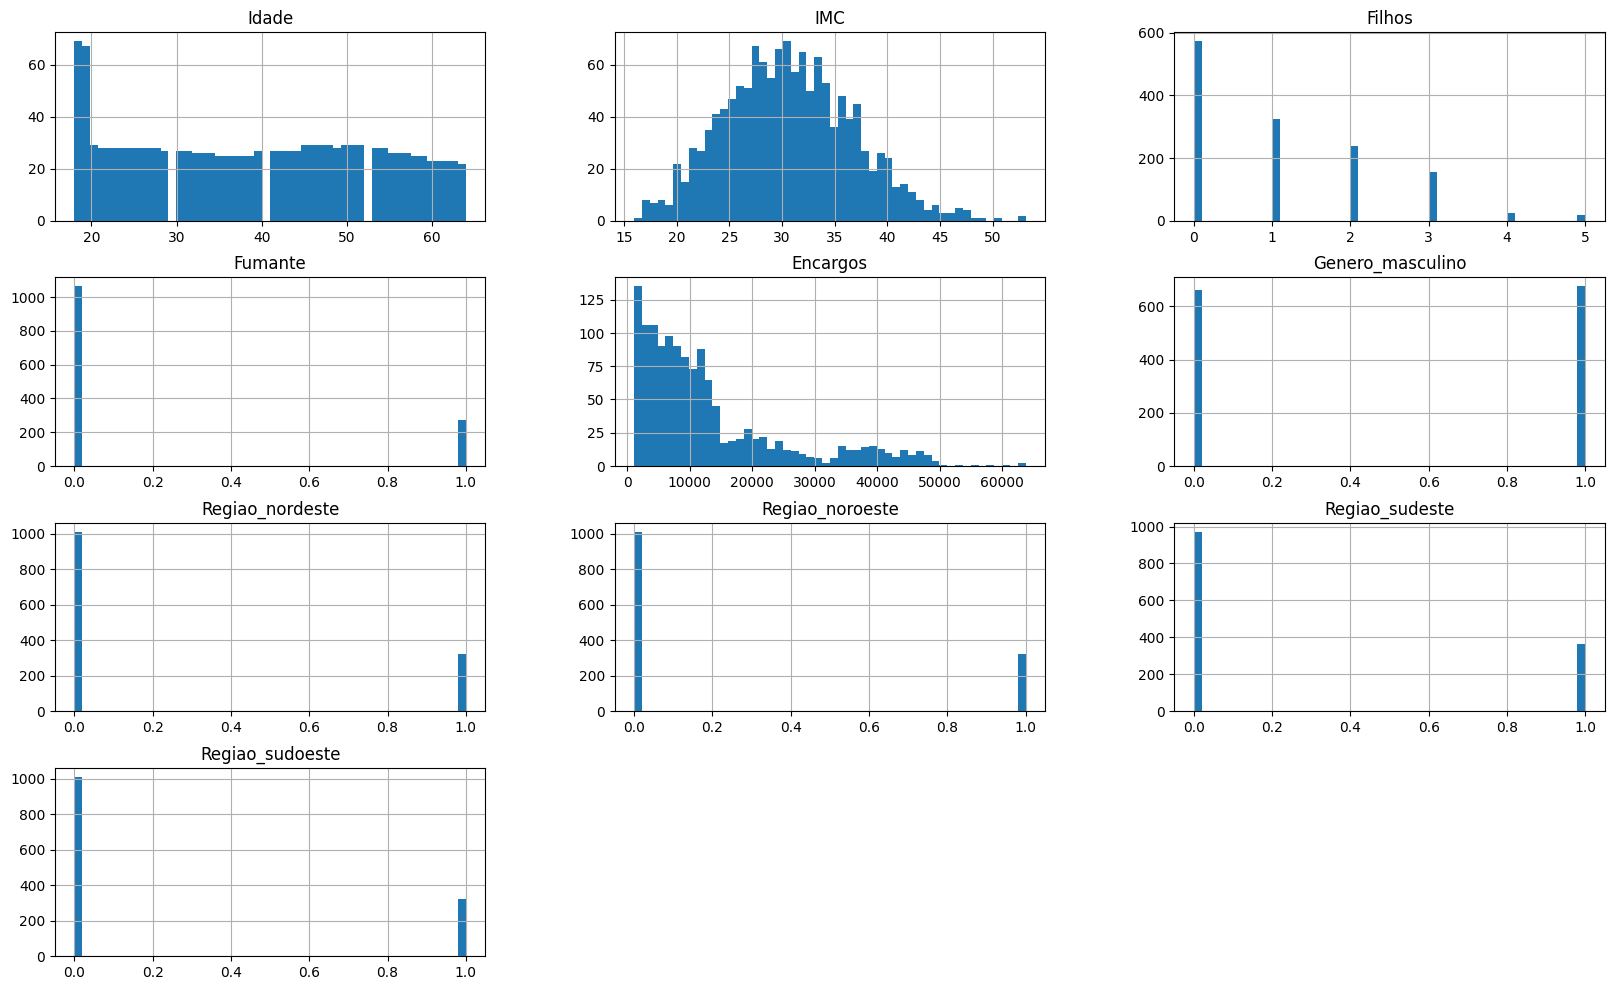

In [11]:
# Análise visual - Histogramas para análise da distribuição dos dados
%matplotlib inline
df.hist(bins=50, figsize=(20,12))

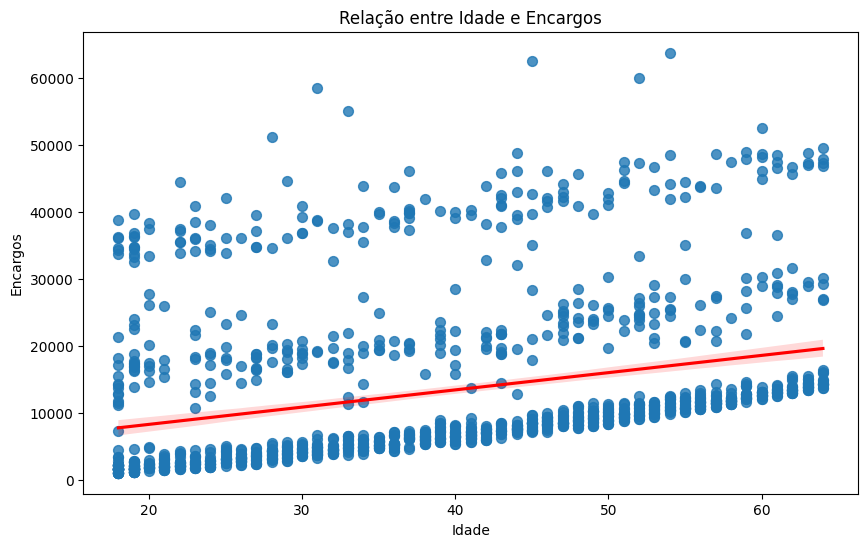

In [12]:
# Análise de dispersão dos dados - Idade e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Idade', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Idade e Encargos')
plt.xlabel('Idade')
plt.ylabel('Encargos')
plt.show()

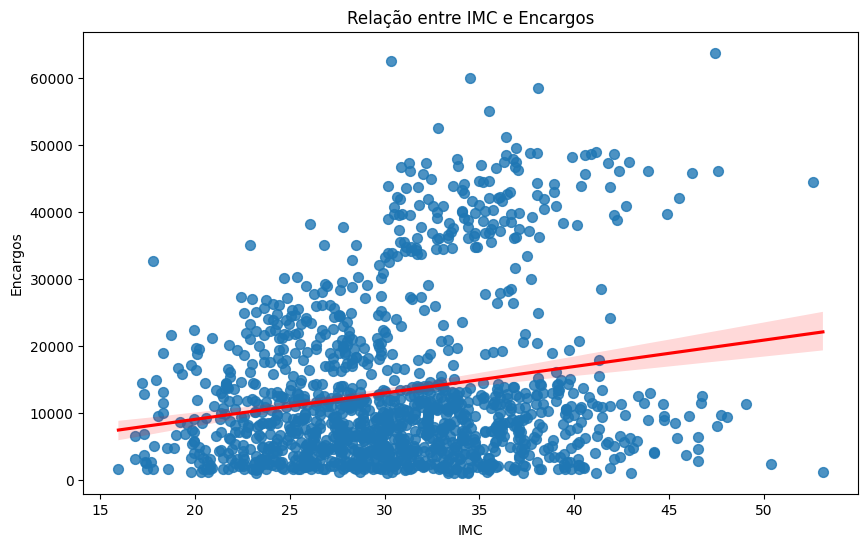

In [13]:
# Análise de dispersão dos dados - IMC e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='IMC', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre IMC e Encargos')
plt.xlabel('IMC')
plt.ylabel('Encargos')
plt.show()

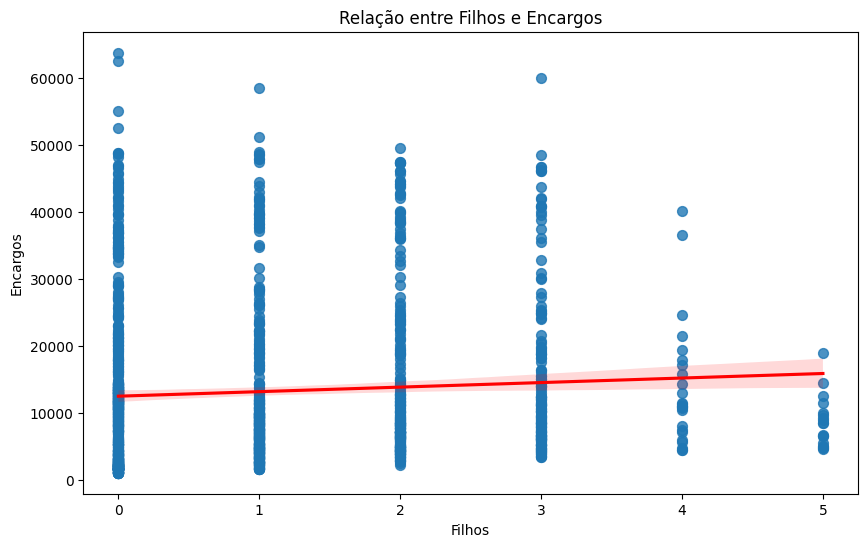

In [14]:
# Análise de dispersão dos dados - Filhos e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Filhos', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Filhos e Encargos')
plt.xlabel('Filhos')
plt.ylabel('Encargos')
plt.show()

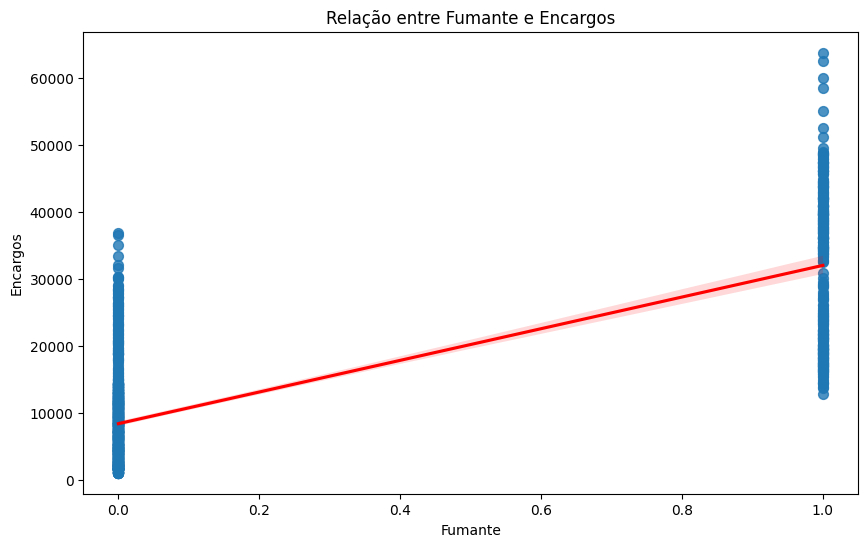

In [15]:
# Análise de dispersão dos dados - Fumante e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Fumante', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Fumante e Encargos')
plt.xlabel('Fumante')
plt.ylabel('Encargos')
plt.show()

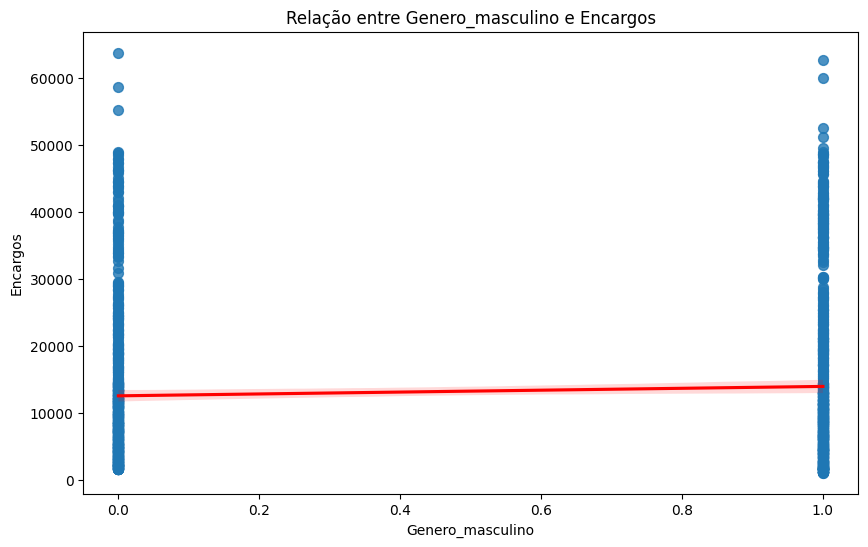

In [16]:
# Análise de dispersão dos dados - Genero e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Genero_masculino', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Genero_masculino e Encargos')
plt.xlabel('Genero_masculino')
plt.ylabel('Encargos')
plt.show()

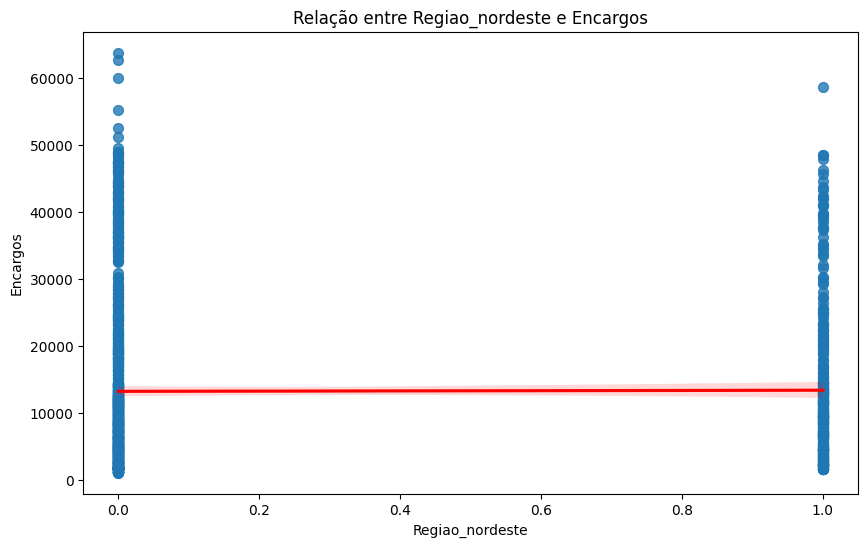

In [17]:
# Análise de dispersão dos dados - Regiao_nordeste e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Regiao_nordeste', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Regiao_nordeste e Encargos')
plt.xlabel('Regiao_nordeste')
plt.ylabel('Encargos')
plt.show()

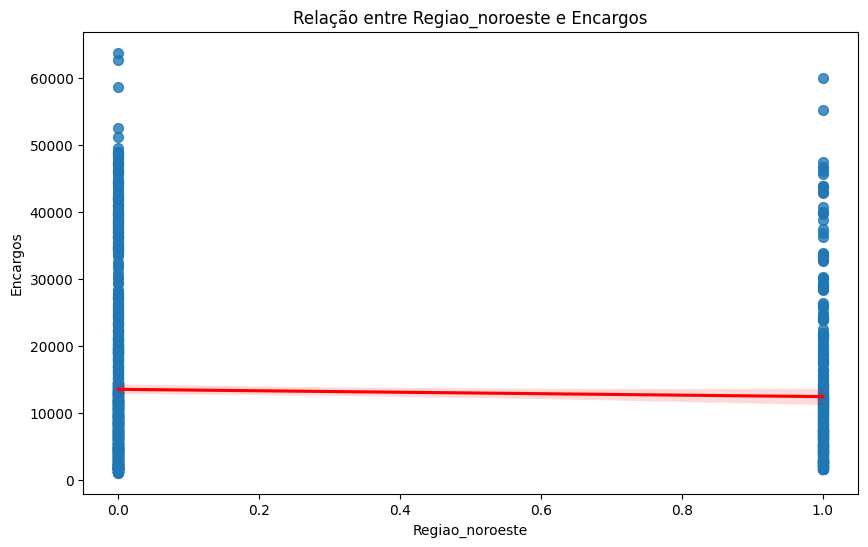

In [18]:
# Análise de dispersão dos dados - Regiao_noroeste e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Regiao_noroeste', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Regiao_noroeste e Encargos')
plt.xlabel('Regiao_noroeste')
plt.ylabel('Encargos')
plt.show()

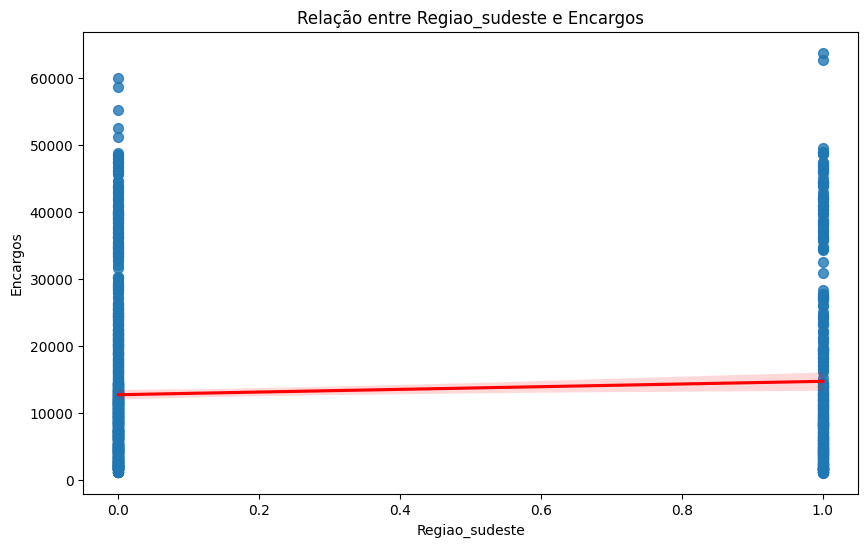

In [19]:
# Análise de dispersão dos dados - Regiao_sudeste e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Regiao_sudeste', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Regiao_sudeste e Encargos')
plt.xlabel('Regiao_sudeste')
plt.ylabel('Encargos')
plt.show()

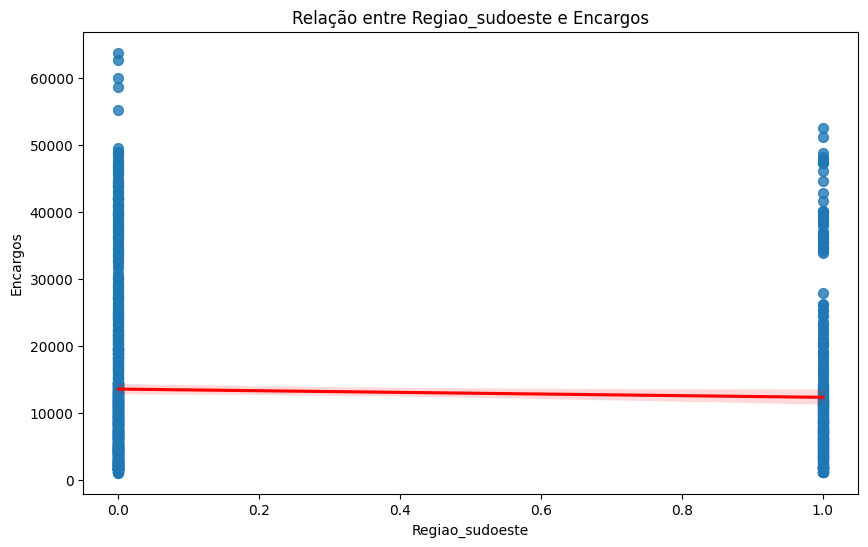

In [20]:
# Análise de dispersão dos dados - Regiao_sudoeste e Encargos
plt.figure(figsize=(10, 6))
sns.regplot(x='Regiao_sudoeste', y='Encargos', data=df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Relação entre Regiao_sudoeste e Encargos')
plt.xlabel('Regiao_sudoeste')
plt.ylabel('Encargos')
plt.show()

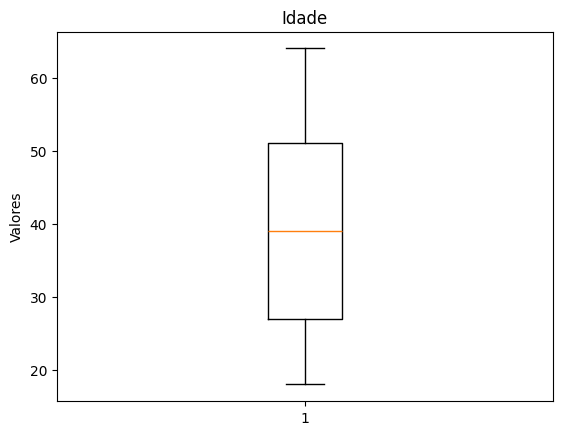

In [21]:
# Boxplot da Idade
plt.boxplot(df['Idade'])
plt.title('Idade')
plt.ylabel('Valores')
plt.show()

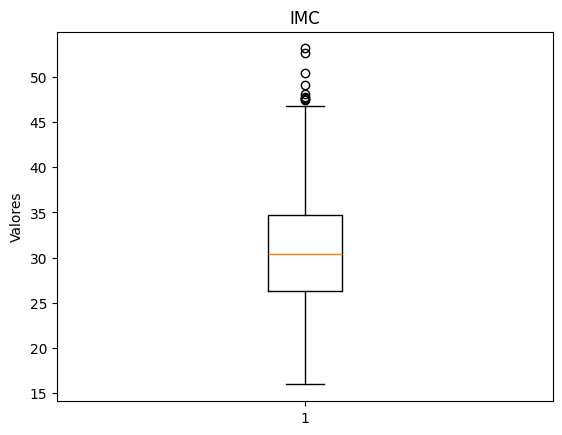

In [22]:
# Boxplot do IMC
plt.boxplot(df['IMC'])
plt.title('IMC')
plt.ylabel('Valores')
plt.show()

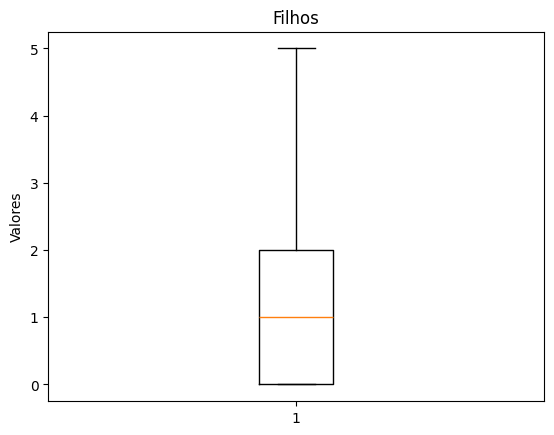

In [23]:
# Boxplot de Filhos
plt.boxplot(df['Filhos'])
plt.title('Filhos')
plt.ylabel('Valores')
plt.show()

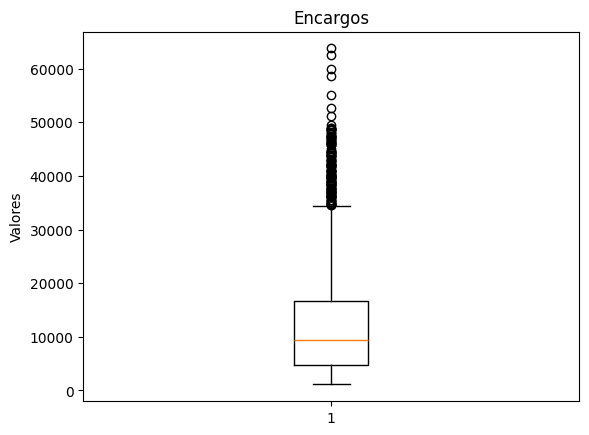

In [24]:
# Boxplot de Encargos
plt.boxplot(df['Encargos'])
plt.title('Encargos')
plt.ylabel('Valores')
plt.show()

Nota-se a presença de outliers, principalmente nos valores mais altos de encargos e IMC. No entanto, para preservar o tamanho da base de dados, que não é tão grande, e manter os valores originais, esses outliers serão mantidos. Uma possível solução poderia ser balancear a base, adicionando mais dados disponíveis. Isso poderia ser feito coletando mais amostras ou utilizando técnicas de oversampling, como o SMOTE (Synthetic Minority Over-sampling Technique).

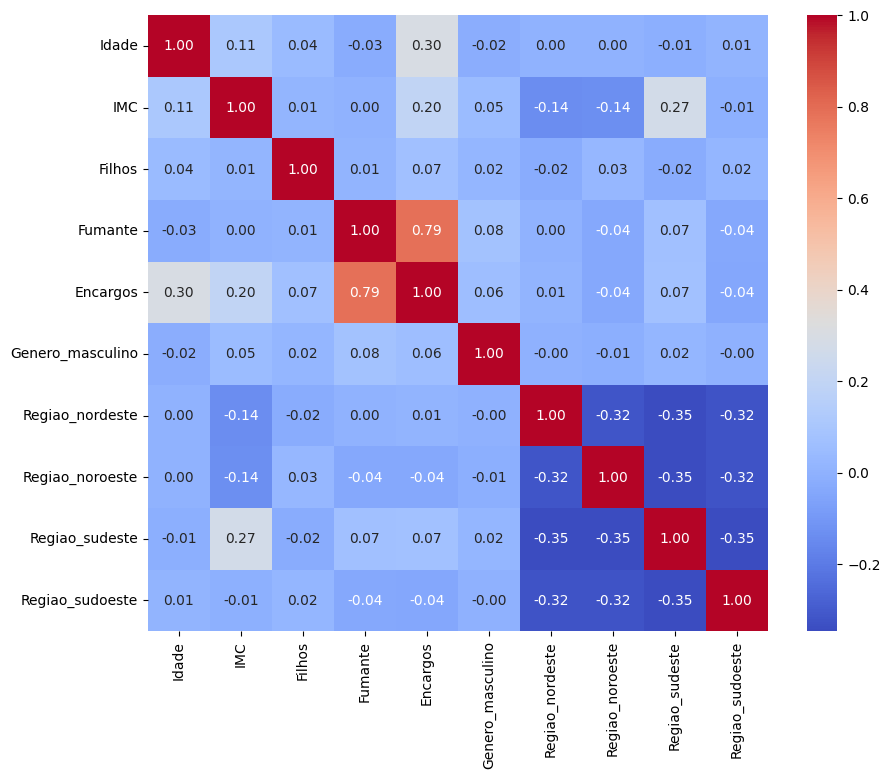

In [25]:
# Realizando o mapa de calor para visualizar a correlação das variáveis

# Calculando a matriz de correlação
corr = df.select_dtypes(include=['number']).corr()

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Criando o mapa de calor da matriz de correlação
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

A variável com maior correlação com os encargos é ser fumante, seguida pela idade e IMC. As outras variáveis têm correlações fracas ou quase inexistentes.

In [26]:
# Verificando correlação das variáveis com Encargos
print("Correlação com o alvo (Encargos):")
print(df.corr()['Encargos'])

Correlação com o alvo (Encargos):
Idade               0.298308
IMC                 0.198401
Filhos              0.067389
Fumante             0.787234
Encargos            1.000000
Genero_masculino    0.058044
Regiao_nordeste     0.005945
Regiao_noroeste    -0.038695
Regiao_sudeste      0.073578
Regiao_sudoeste    -0.043637
Name: Encargos, dtype: float64


## Modelagem

### Separação das Variáveis

Primeiramente, separamos as variáveis independentes (features) da variável dependente (target). As features incluem idade, gênero, IMC, número de filhos, se a pessoa é fumante ou não, e a região onde reside. A variável target é o custo médico individual.

In [27]:
# Separação das Features e do Target
X = df.drop(columns=['Encargos'], axis=1) # Variáveis características/independetes
y = df['Encargos'] # Target/Variável dependente

# Divisão dos dados em conjuntos de Teste e Treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Para facilitar o processo de pré-processamento e modelagem, utilizamos uma pipeline. A pipeline permite que todas as etapas do pré-processamento e modelagem sejam executadas de forma sequencial. Além disso, utilizaremos o GridSearch para encontrar os melhores hiperparâmetros para o modelo.

In [28]:
# Criar a pipeline para funcionar para os modelos
pipeline = Pipeline([
    ('preprocess', 'passthrough'),  # Placeholder para o pré-processamento
    ('model', LinearRegression())
])

## Definição dos Parâmetros para GridSearchCV
- **Pré-processadores**: `StandardScaler` (padronização), `MinMaxScaler` (normalização), `passthrough` (dados brutos)
- **Modelos**: `LinearRegression`, `RandomForestRegressor`, `SVR`, `KNeighborsRegressor`, `GradientBoostingRegressor`
- **Parâmetros Específicos**:
  - `RandomForestRegressor`: `n_estimators`, `max_depth`, `min_samples_split`
  - `SVR`: `C`, `kernel`, `gamma`, `epsilon`
  - `KNeighborsRegressor`: `n_neighbors`, `weights`, `metric`, `leaf_size`
  - `GradientBoostingRegressor`: `n_estimators`, `learning_rate`, `max_depth`

In [29]:
# Definir os parâmetros para GridSearchCV
param_grid = [
    {'preprocess': [StandardScaler()], 'model': [LinearRegression()]},
    {'preprocess': [MinMaxScaler()], 'model': [LinearRegression()]},
    {'preprocess': ['passthrough'], 'model': [LinearRegression()]},

    {'preprocess': [StandardScaler()], 'model': [RandomForestRegressor(random_state=42)], 'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},
    {'preprocess': [MinMaxScaler()], 'model': [RandomForestRegressor(random_state=42)], 'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},
    {'preprocess': ['passthrough'], 'model': [RandomForestRegressor(random_state=42)], 'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},

    {'preprocess': [StandardScaler()], 'model': [SVR()], 'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'poly', 'rbf'], 'model__gamma': ['scale', 'auto'], 'model__epsilon': [0.1, 0.2, 0.5]},
    {'preprocess': [MinMaxScaler()], 'model': [SVR()], 'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'poly', 'rbf'], 'model__gamma': ['scale', 'auto'], 'model__epsilon': [0.1, 0.2, 0.5]},
    # {'preprocess': ['passthrough'], 'model': [SVR()], 'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'poly', 'rbf'], 'model__gamma': ['scale', 'auto'], 'model__epsilon': [0.1, 0.2, 0.5]},

    {'preprocess': [StandardScaler()], 'model': [KNeighborsRegressor()], 'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance'], 'model__metric': ['euclidean', 'manhattan', 'minkowski'], 'model__leaf_size': [30, 50, 70]},
    {'preprocess': [MinMaxScaler()], 'model': [KNeighborsRegressor()], 'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance'], 'model__metric': ['euclidean', 'manhattan', 'minkowski'], 'model__leaf_size': [30, 50, 70]},
    # {'preprocess': ['passthrough'], 'model': [KNeighborsRegressor()], 'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance'], 'model__metric': ['euclidean', 'manhattan', 'minkowski'], 'model__leaf_size': [30, 50, 70]},

    {'preprocess': [StandardScaler()], 'model': [GradientBoostingRegressor(random_state=42)], 'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [3, 5, 7]},
    {'preprocess': [MinMaxScaler()], 'model': [GradientBoostingRegressor(random_state=42)], 'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [3, 5, 7]},
    {'preprocess': ['passthrough'], 'model': [GradientBoostingRegressor(random_state=42)], 'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [3, 5, 7]}
]

## Treinamento e avaliação do modelo

### Busca em Grade (GridSearchCV)
- Criação de um objeto `GridSearchCV` com a grade de parâmetros.
- Utilização de validação cruzada (`cv=5`) e métrica de erro quadrático médio negativo (`scoring='neg_mean_squared_error'`).
- Ajuste (`fit`) aos dados de treinamento (`X_train`, `y_train`).

In [30]:
# Realizar a busca em grade (GridSearchCV)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', 'passthrough'),
                                       ('model', LinearRegression())]),
             param_grid=[{'model': [LinearRegression()],
                          'preprocess': [StandardScaler()]},
                         {'model': [LinearRegression()],
                          'preprocess': [MinMaxScaler()]},
                         {'model': [LinearRegression()],
                          'preprocess': ['passthrough']},
                         {'model': [RandomForestRegressor(random_state=42)],...
                         {'model': [GradientBoostingRegressor(random_state=42)],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [3, 5, 7],
                          'model__n_estimators': [50, 100, 200],
                          'preprocess': [MinMaxScaler()]},
                         {'model': [GradientBoostingRegressor(random_state=42)],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [3, 5, 7],
                          'model__n_estimators': [50, 100, 200],
                          'preprocess': ['passthrough']}],
             scoring='neg_mean_squared_error')

### Melhor Modelo e Parâmetros
- Obtenção do melhor modelo e seus parâmetros a partir da busca em grade.
- Impressão do melhor modelo e dos melhores parâmetros.

In [31]:
# Melhor modelo e parâmetros
best_model = grid_search.best_estimator_
print("Melhor modelo:", best_model)
print("Melhores parâmetros:", grid_search.best_params_)

Melhor modelo: Pipeline(steps=[('preprocess', 'passthrough'),
                ('model',
                 GradientBoostingRegressor(n_estimators=50, random_state=42))])
Melhores parâmetros: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'preprocess': 'passthrough'}


Na etapa anterior, o melhor modelo foi escolhido com base no Mean Squared Error (MSE), e o modelo selecionado foi o Gradient Boosting. Observa-se agora que o R^2 Score foi de 0.90, indicando que 90% da variância nos dados de saída é explicada pelo modelo, o que é um excelente resultado.

In [32]:
# Avaliar o modelo no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 18062561.40
Root Mean Squared Error: 4250.01
Mean Absolute Error: 2493.86
R^2 Score: 0.90


## Validação estatística

A maioria dos pontos azuis parece estar próxima da linha de tendência, o que indica que o modelo está fazendo boas predições na maioria dos casos. No entanto, há alguns pontos que se afastam significativamente da linha, sugerindo que o modelo pode ter dificuldades em prever corretamente para esses casos específicos, muito provavelmente por conta dos outliers que foram mantidos durante a etapa de análise dos dados. A mesma situação também pode ser observada no gráfico de resíduos, com valores pontuais com resíduos maiores que, contudo, não estão distribuídos em uma faixa específica.

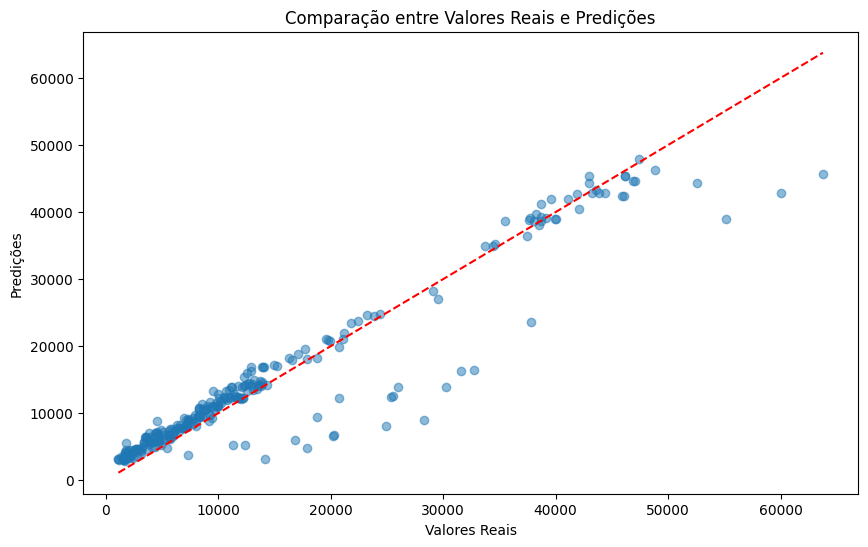

In [33]:
# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Predições')
plt.title('Comparação entre Valores Reais e Predições')
plt.show()

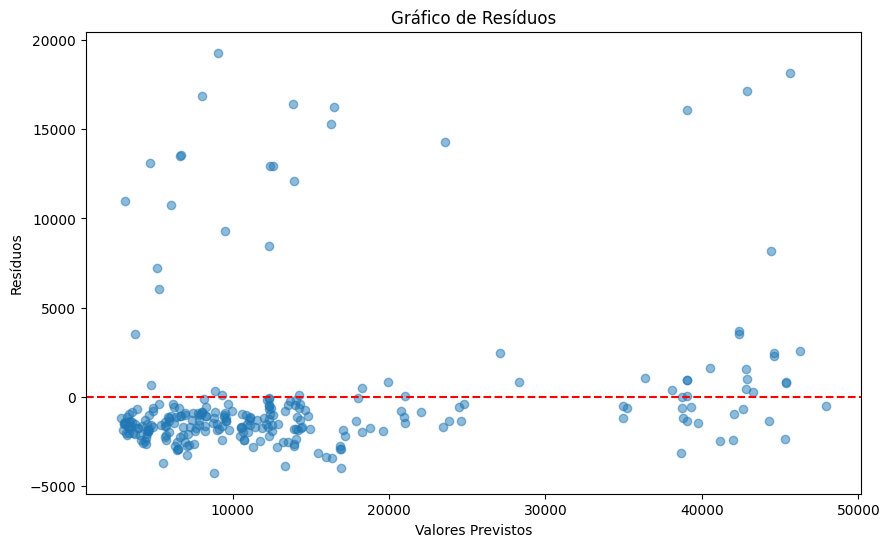

In [34]:
# Calculando os resíduos
residuos = y_test - y_pred

# Criando o gráfico de resíduos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()


### Coeficientes e P-valores

- **const**: -9252.0860 (p < 0.000) - O intercepto do modelo.
- **Idade**: 248.2107 (p < 0.000) - A idade tem um impacto positivo significativo nos encargos.
- **IMC**: 318.7014 (p < 0.000) - O IMC também tem um impacto positivo significativo nos encargos.
- **Filhos**: 533.0100 (p = 0.001) - O número de filhos tem um impacto positivo significativo nos encargos.
- **Fumante**: 2.308e+04 (p < 0.000) - Ser fumante tem um impacto extremamente significativo e positivo nos encargos.
- **Genero_masculino**: -101.5421 (p = 0.787) - O gênero masculino não tem um impacto significativo nos encargos.
- **Regiao_nordeste**: -1840.5663 (p < 0.000) - Residir na região Nordeste tem um impacto negativo significativo nos encargos.
- **Regiao_noroeste**: -2232.3277 (p < 0.000) - Residir na região Noroeste tem um impacto negativo significativo nos encargos.
- **Regiao_sudeste**: -2679.4859 (p < 0.000) - Residir na região Sudeste tem um impacto negativo significativo nos encargos.
- **Regiao_sudoeste**: -2499.7060 (p < 0.000) - Residir na região Sudoeste tem um impacto negativo significativo nos encargos.

In [35]:
# Adicionar uma constante aos dados (necessário para statsmodels)
X_train_const = sm.add_constant(X_train.astype(float))

# Ajustar o modelo de regressão linear
modelo = sm.OLS(y_train, X_train_const).fit()

# Obter o resumo do modelo, que inclui os p-valores
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:               Encargos   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.1
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          4.94e-295
Time:                        14:05:11   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9252.0860    882.424  

Os intervalos de confiança são uma ferramenta estatística que nos ajuda a entender a precisão das estimativas de um modelo. Eles fornecem um intervalo dentro do qual esperamos que o valor verdadeiro de um parâmetro caia, com uma certa probabilidade. Um intervalo de confiança de 95% significa que se repetirmos o experimento ou a amostragem 100 vezes, esperamos que o valor verdadeiro do parâmetro caia dentro desse intervalo em 95 dessas vezes. A largura do intervalo de confiança nos dá uma ideia da precisão da estimativa. Intervalos mais estreitos indicam estimativas mais precisas, enquanto intervalos mais largos sugerem maior incerteza.

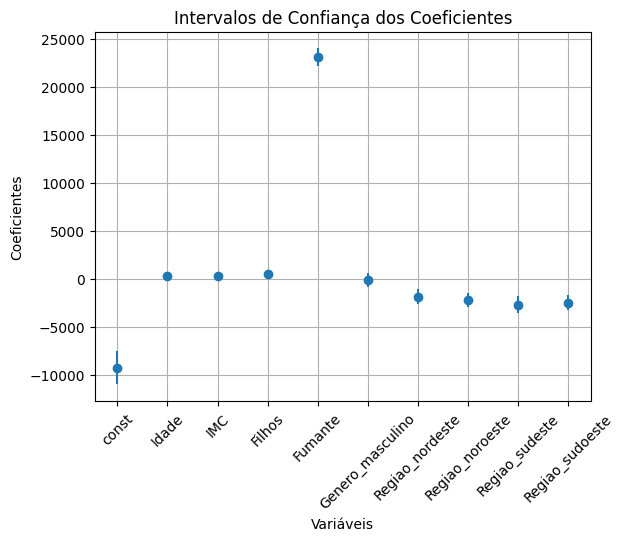

In [36]:
# Calcular os intervalos de confiança
coef = modelo.params
conf_int = modelo.conf_int(alpha=0.05)

plt.errorbar(coef.index, coef.values, 
             yerr=[coef - conf_int[0], conf_int[1] - coef], fmt='o')
plt.title("Intervalos de Confiança dos Coeficientes")
plt.xlabel("Variáveis")
plt.ylabel("Coeficientes")
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Avaliação dos Intervalos de Confiança
- Variáveis como idade, IMC, número de filhos e ser fumante têm impactos positivos nos custos médicos.
- Variáveis de região geralmente têm impactos negativos.
- Gênero masculino tem um impacto misto, portanto podendo não ser estatisticamente significativo.
- A precisão das estimativas varia, com alguns intervalos de confiança sendo mais estreitos (maior precisão) e outros mais amplos (maior incerteza).


In [37]:
print(conf_int)

                             0             1
const            -10983.581788  -7520.590215
Idade               221.706568    274.714872
IMC                 254.844680    382.558202
Filhos              225.343640    840.676338
Fumante           22153.507868  24002.021318
Genero_masculino   -838.913537    635.829429
Regiao_nordeste   -2581.877899  -1099.254690
Regiao_noroeste   -2973.287809  -1491.367690
Regiao_sudeste    -3532.764427  -1826.207394
Regiao_sudoeste   -3268.525210  -1730.886882


### Conclusão do Modelo

O modelo de regressão `GradientBoostingRegressor` apresentou um desempenho robusto na previsão dos custos médicos individuais. As métricas de avaliação indicam uma boa precisão do modelo, com um **R^2 Score** de 0.90, sugerindo que o modelo explica 90% da variabilidade nos custos médicos.

### Principais Resultados
- **Erro Quadrático Médio (MSE)**: 18,062,561.40
- **Raiz do Erro Quadrático Médio (RMSE)**: 4,250.01
- **Erro Absoluto Médio (MAE)**: 2,493.86

### Análise das Variáveis
- **Idade, IMC, Número de Filhos e Ser Fumante**: Têm impactos positivos significativos nos custos médicos, indicando que à medida que essas variáveis aumentam, os custos médicos também tendem a aumentar.
- **Regiões (Nordeste, Noroeste, Sudeste, Sudoeste)**: Têm impactos negativos significativos nos custos médicos, sugerindo que residir nessas regiões está associado a custos médicos mais baixos.
- **Gênero Masculino**: Não apresentou um impacto significativo nos custos médicos.

### Observações Finais
- O modelo está fazendo boas predições na maioria dos casos, conforme indicado pela proximidade dos pontos azuis à linha de tendência.
- Alguns pontos se afastam significativamente da linha de tendência, possivelmente devido à presença de outliers.
- O gráfico de resíduos mostra valores pontuais com resíduos maiores, mas não distribuídos em uma faixa específica, indicando que o modelo pode ser melhorado para lidar com esses casos específicos.

### Possiveis melhorias
- **Tratamento de Outliers**: Considerar técnicas de tratamento de outliers para melhorar a precisão do modelo.
- **Ajuste de Hiperparâmetros**: Explorar ajustes adicionais nos hiperparâmetros do modelo para potencialmente melhorar o desempenho.